#### Pré processamento

In [95]:
import re

def capitalizar_palavras(texto):
    return ' '.join(palavra.capitalize() for palavra in texto.split())

# Compilação fora da função (melhor desempenho)
URL_MENCAO_REGEX = re.compile(r"http\S+|www\S+|https\S+|@\w+|#")
EMOJI_SYMBOL_REGEX = re.compile(r"[^\w\s\-áéíóúâêôãõç]", flags=re.UNICODE)
ABREVIACOES = {
    "q": "que", "pq": "porque", "vc": "você", "vcs": "vocês", "tb": "também",
    "blz": "beleza", "hj": "hoje", "amanha": "amanhã", "mt": "muito", "td": "tudo",
    "obg": "obrigado", "vlw": "valeu", "msg": "mensagem", "n": "não", "s": "sim",
    "tbm": "também", "p": "para", "nao": "não"
}

ABREVIACOES_REGEX = re.compile(r'\b(' + '|'.join(map(re.escape, ABREVIACOES.keys())) + r')\b', flags=re.IGNORECASE)

def substituir_abreviacoes(match):
    palavra = match.group(0).lower()
    return ABREVIACOES.get(palavra, palavra)

def limpar_texto_bruto(texto: str) -> str:
    texto = URL_MENCAO_REGEX.sub(" ", texto)
    texto = ABREVIACOES_REGEX.sub(substituir_abreviacoes, texto)
    texto = EMOJI_SYMBOL_REGEX.sub(" ", texto)  
    return texto


In [127]:
import spacy
import nltk
from spacy.matcher import Matcher

nlp = spacy.load('pt_core_news_lg')
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

# Matcher para padrões como "20 mil pessoas" e datas
matcher = Matcher(nlp.vocab)

PRONOMES_OBLIQUOS = {"lo", "la", "los", "las", "le", "les", "me", "te", "se", "nos", "vos"}

padrao_cardinal_substantivo = [
    {"LIKE_NUM": True},
    {"LOWER": {"IN": ["mil", "milhão", "milhões", "bilhão", "bilhões"]}, "OP": "?"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
padrao_num_extenso = [
    {"POS": "NUM"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
padrao_ordinal = [
    {"TAG": "ORD"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
matcher.add("NUM_UNIDADE", [padrao_cardinal_substantivo, padrao_num_extenso, padrao_ordinal])


# Verbos principais e auxiliares
padrao_verbo = [{"POS": {"IN": ["VERB"]}}]

# Substantivos comuns
padrao_substantivo = [{"POS": "NOUN"}]

# Substantivos próprios (nomes de pessoas, lugares, marcas etc.)
padrao_proprio = [{"POS": "PROPN"}]

# Adjetivos (qualificações, características)
padrao_adjetivo = [{"POS": "ADJ"}]

# Opcional: advérbios de modo ou intensidade
padrao_adverbio = [{"POS": "ADV"}]

#matcher.add("VERBOS", [padrao_verbo])
matcher.add("SUBSTANTIVOS", [padrao_substantivo])
matcher.add("PROPRIOS", [padrao_proprio])
matcher.add("ADJETIVOS", [padrao_adjetivo])
#matcher.add("ADVERBIOS", [padrao_adverbio])


In [103]:
from spacy.util import filter_spans

def pre_processamento_ent_numeros(texto):
    texto = limpar_texto_bruto(texto)
    doc = nlp(texto)

    # Identifica spans compostos (ex: "vinte mil pessoas")
    matches = matcher(doc)
    spans = [doc[start:end] for _, start, end in matches]
    spans_filtrados = filter_spans(spans)

    # Mapeia início do span -> span para evitar tokenização duplicada
    spans_dict = {span.start: span for span in spans_filtrados}
    ent_by_start = {ent.start: ent for ent in doc.ents}

    tokens = []
    i = 0
    while i < len(doc):
        #lida com entidades
        if i in ent_by_start: 
            ent = ent_by_start[i]
            ent_text = capitalizar_palavras(ent.text.lower())
            tokens.append(ent_text)
            i = ent.end
        #lida com matchers  - substantivos, substantivos proprios e adjetivos
        elif i in spans_dict:
            span = spans_dict[i]
            span_text = span.text.lower()
            #quando é somente uma palavra
            if len(span) == 1:
                if span[0].pos_ == "VERB":
                    tokens.append(span[0].lemma_)
                elif span[0].is_alpha and span not in stopwords and len(span_text) >= 3:
                    tokens.append(span_text)
            elif len(span_text) >= 3:
                tokens.append(span_text)
            i = span.end
        #ignora demais
        else: 
            i += 1        

    return tokens


In [104]:
from enelvo.normaliser import Normaliser
import csv

resultado = [] 
valores = []

with open('datasets/vacinal_twitter.csv', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for line in reader:
      txt = line['description']
      valores.append(txt)
      pre_proc = pre_processamento_ent_numeros(txt)
      resultado.append(pre_proc)
      

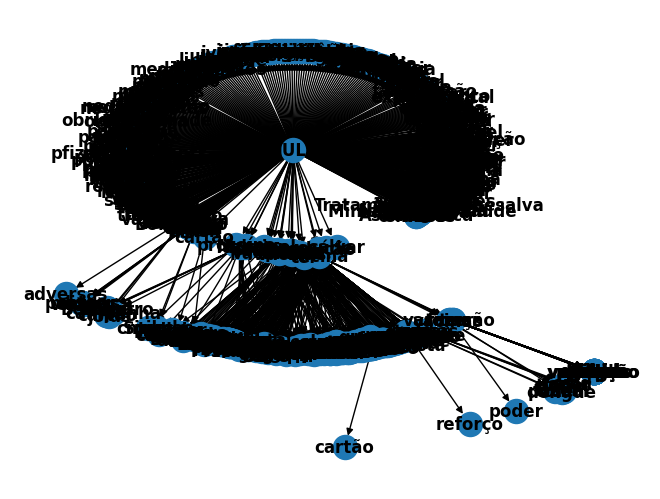

In [109]:
from trieofrules import trieofrules

#supported algorithms: FP-max, FP-growth, Apriori
TOR = trieofrules(data = resultado, alg='Apriori', min_support=0.003) 
TOR.draw()
TOR.save_graph(filename = 'outputs/vacinal_twitter.graphml') 

In [ ]:
import pandas as pd

# Lê o arquivo CSV
df = pd.read_csv("datasets/vacinal_twitter.csv")

# Seleciona 10 mil linhas aleatórias
amostra = df.sample(n=80000, random_state=42)

# Exibe as primeiras linhas
print(amostra.head())

# Salva como novo CSV
amostra.to_csv("amostra_80_mil.csv", index=False)


In [ ]:
import pandas as pd

#caminho_arquivo = 'datasets/vacinal_twitter.csv'
caminho_arquivo = 'datasets/vacinal_2025_06_03.csv'
df = pd.read_csv(caminho_arquivo)

df['createdAt'] = pd.to_datetime(df['createdAt'], format='mixed')

menor_data = df['createdAt'].min()
maior_data = df['createdAt'].max()

print(f"A menor data é: {menor_data}")
print(f"A maior data é: {maior_data}")

df.head()

In [122]:
# 1. Converte a coluna 'createdAt' para datetime, lidando com formatos mistos
df['createdAt'] = pd.to_datetime(df['createdAt'], format='mixed')

# 2. Ordena o DataFrame pela coluna 'createdAt'
df_ordenado = df.sort_values(by='createdAt')

# 3. Filtra os dados a partir de 1º de janeiro de 2025
data_limite = pd.Timestamp('2025-01-01')
df_new_database = df_ordenado[df_ordenado['createdAt'] >= data_limite]

num_linhas = len(df_new_database)
print(f"A base tem {num_linhas} linhas.")

df_new_database['createdAt'] = pd.to_datetime(df_new_database['createdAt'], format='mixed')

# Encontra a menor e maior data
menor_data = df_new_database['createdAt'].min()
maior_data = df_new_database['createdAt'].max()

print(f"A menor data é: {menor_data}")
print(f"A maior data é: {maior_data}")

# 4. Exibe a nova tabela
#df_new_database.head()

df_new_database.to_csv('database_2025.csv', index=False)


A base tem 8413 linhas.
A menor data é: 2025-01-01 01:42:32.216000
A maior data é: 2025-06-03 23:54:55.440000


C:\Users\luiza\AppData\Local\Temp\ipykernel_10620\2392462642.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_database['createdAt'] = pd.to_datetime(df_new_database['createdAt'], format='mixed')


In [ ]:
from enelvo.normaliser import Normaliser
import csv

resultado = [] 
valores = []

with open('datasets/database_2025.csv', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for line in reader:
      txt = line['description']
      valores.append(txt)
      pre_proc = pre_processamento_ent_numeros(txt)
      resultado.append(pre_proc)
      

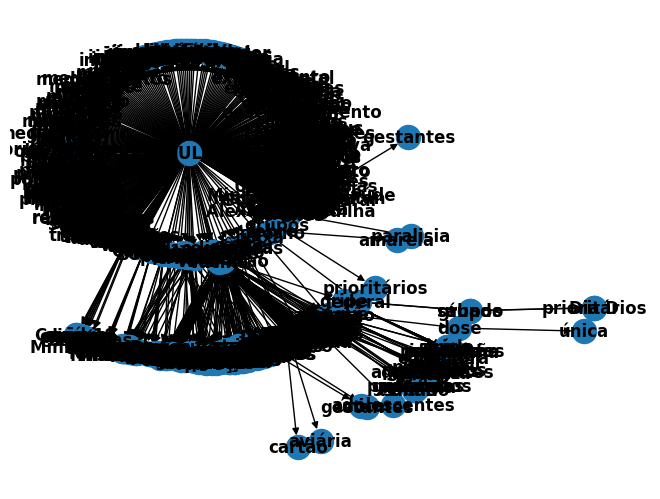

In [130]:
from trieofrules import trieofrules

#supported algorithms: FP-max, FP-growth, Apriori
TOR = trieofrules(data = resultado, alg='Apriori', min_support=0.003) 
TOR.draw()
TOR.save_graph(filename = 'outputs/database_2025.graphml') 

In [ ]:
import networkx as nx

# 1. Carrega o grafo
G = nx.read_graphml("outputs/database_2025.graphml")

# 2. Remove o nó central (por exemplo, o nó "0")
if "0" in G:
    G.remove_node("0")

# 3. Converte para grafo não-direcionado para detectar componentes fracos
UG = G.to_undirected()

# 4. Detecta clusters (componentes conectados)
clusters = list(nx.connected_components(UG))

# 5. Ordena clusters por tamanho
clusters.sort(key=len, reverse=True)

# 6. Exibe clusters ignorando isolados de 1 nó (se desejar)
for i, cluster in enumerate(clusters):
    if len(cluster) <= 1:
        continue  # Ignora clusters triviais
    print(f"Cluster {i+1} ({len(cluster)} nós):")
    palavras = [G.nodes[n]["value"] for n in cluster] 
    print(", ".join(palavras))
    print("-" * 40)



Cluster 1 (124 nós):
mortes, saúde, ciência, influenza, saúde, Bolsonaro, imunização, proteção, Butantan, dose, dose, febre, segunda, adolescentes, vida, amarela, única, Brasil, única, Anvisa, brasileira, campanha, baixa, população, boa, Lula, primeira, chikungunya, Dengue, Astrazeneca, única, Ministério Da Saúde, terapia, disponível, ano, Brasil, grande, partir, primeira, aumento, dengue, imunizante, gestantes, estudos, risco, cartão, vacina, criança, país, 6 meses, novas, vidas, falta, uso, doença, Covid, presidente, mrna, notícia, produção, Pfizer, vírus, causa, testes, importante, sarampo, braço, Hpv, doses, caso, grupos, câncer, reforço, coisa, maior, nacional, brasileiros, estudo, idade, aplicação, vacinação, crianças, mundo, pandemia, idosos, governo, Eua, tipo, fraude, graves, sábado, Instituto Butantan, gripe, prevenção, nova, pessoas, efeitos, nacional, amarela, cara, gripe, sus, covid, forma, dia, povo, semana, única, pais, morte, casos, vacinas, cartão, adolescentes, Saúde,